In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.rcParams.update({
    'font.family': 'serif',  # or 'sans-serif'
    'font.size': 10,         # base font size
    'axes.labelsize': 10,    # axis label size
    'axes.titlesize': 12,    # title size
    'xtick.labelsize': 8,    # x-axis tick label size
    'ytick.labelsize': 8,    # y-axis tick label size
    'legend.fontsize': 8,    # legend font size
})

DATASET_COLORS = {
    "trivia_qa_2_60k": "#000000",    # black
    "cities_10k": "#e41a1c",         # red
    "gsm8k": "#4daf4a",              # green
    "math_operations_6k": "#377eb8",  # darker yellow (gold)
    "medals_9k": "#ff7f00",          # orange
    "birth_years_4k": "#984ea3",     # purple
}
DATASET_MARKERS = {
    "trivia_qa_2_60k": "o",    # circle
    "cities_10k": "s",          # square
    "gsm8k": "D",              # diamond
    "math_operations_6k": "^",  # triangle up
    "medals_9k": "X",          # uppercase X for thicker x
    "birth_years_4k": "P",      # uppercase P for thicker plus
}

mistral_7b_cosine_directions_file = "../best_layer_finding/mistral_7b_instruct/classification_data/res_df_train_test_different_datasets_directions.parquet"
best_layer_mistral_7b = 16 # from aggregate_visualisations.ipynb


LAYER_COUNTS = dict(
    qwen_2_7b_n_layers = 28,
    qwen_32b_n_layers = 64,
    llama3_8b_n_layers = 32,
    llama3_70b_n_layers = 80,
    mistral_8b_n_layers = 36, # ministral
    mistral_7b_n_layers = 32
)

DATASET_NAME_MAP = {
    "trivia_qa_2_60k": "TriviaQA 2 60k",
    "cities_10k": "Cities 10k",
    "gsm8k": "GSM8k",
    "math_operations_6k": "Math Operations 6k",
    "medals_9k": "Medals 9k",
    "birth_years_4k": "Birth Years 4k",
}

In [17]:
# def clean_datset(df):
#     df["prompt_id_train"] = df["prompt_id_train"].str.replace("base_3_shot", "base")
#     df["prompt_id_test"] = df["prompt_id_test"].str.replace("base_3_shot", "base")
#     df = df[df["prompt_id_train"] == "base"]
#     df = df[df["prompt_id_test"] == "base"]
#     return df


In [18]:
mistral_7b_directions_df = pd.read_parquet(mistral_7b_cosine_directions_file)
mistral_7b_directions_df

,model_id_train,dataset_id_train,prompt_id_train,subset_id_train,input_type_train,layer,direction
0,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,0,"[4.029474757771822e-06, 6.620516160182887e-07,..."
1,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,2,"[-6.855938909211545e-06, 6.23058331257198e-06,..."
2,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,4,"[6.940573575775488e-06, 0.00021238350891508161..."
3,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,6,"[1.788870717973623e-05, -9.006585751194506e-05..."
4,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,8,"[-0.00020065212302142755, -7.905954553280025e-..."
...,...,...,...,...,...,...,...
91,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,22,"[0.005188555549830198, 0.015451034530997276, -..."
92,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,24,"[-0.0004150381311774254, 0.017417508363723754,..."
93,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,26,"[-0.001814055722206831, 0.029743877798318864, ..."
94,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,28,"[0.0051390358712524176, 0.04441315680742264, 0..."


In [19]:
layer = best_layer_mistral_7b
mistral_7b_directions_df[mistral_7b_directions_df["layer"] == layer]

,model_id_train,dataset_id_train,prompt_id_train,subset_id_train,input_type_train,layer,direction
8,mistral_7b_instruct,birth_years_4k,base,main,prompt_only,16,"[-0.017527074739336967, 0.016004793345928192, ..."
24,mistral_7b_instruct,cities_10k,base,main,prompt_only,16,"[-0.016986092552542686, 0.00849251113831997, -..."
40,mistral_7b_instruct,gsm8k,base_3_shot,main,prompt_only,16,"[-0.0034711397718638183, 0.0006410917383618652..."
56,mistral_7b_instruct,math_operations_6k,base,main,prompt_only,16,"[0.012068353407084943, 0.00379649056121707, 0...."
72,mistral_7b_instruct,medals_9k,base,main,prompt_only,16,"[-0.003250507777556777, -0.0006426670122891664..."
88,mistral_7b_instruct,trivia_qa_2_60k,base,main,prompt_only,16,"[-0.006639179680496455, 0.0075224913656711575,..."


In [21]:
from scipy.spatial.distance import cosine

def cosine_similarity_distribution(dir1, dir2):
    dir1 = np.array(dir1)
    dir2 = np.array(dir2)
    return 1 - cosine(dir1, dir2)

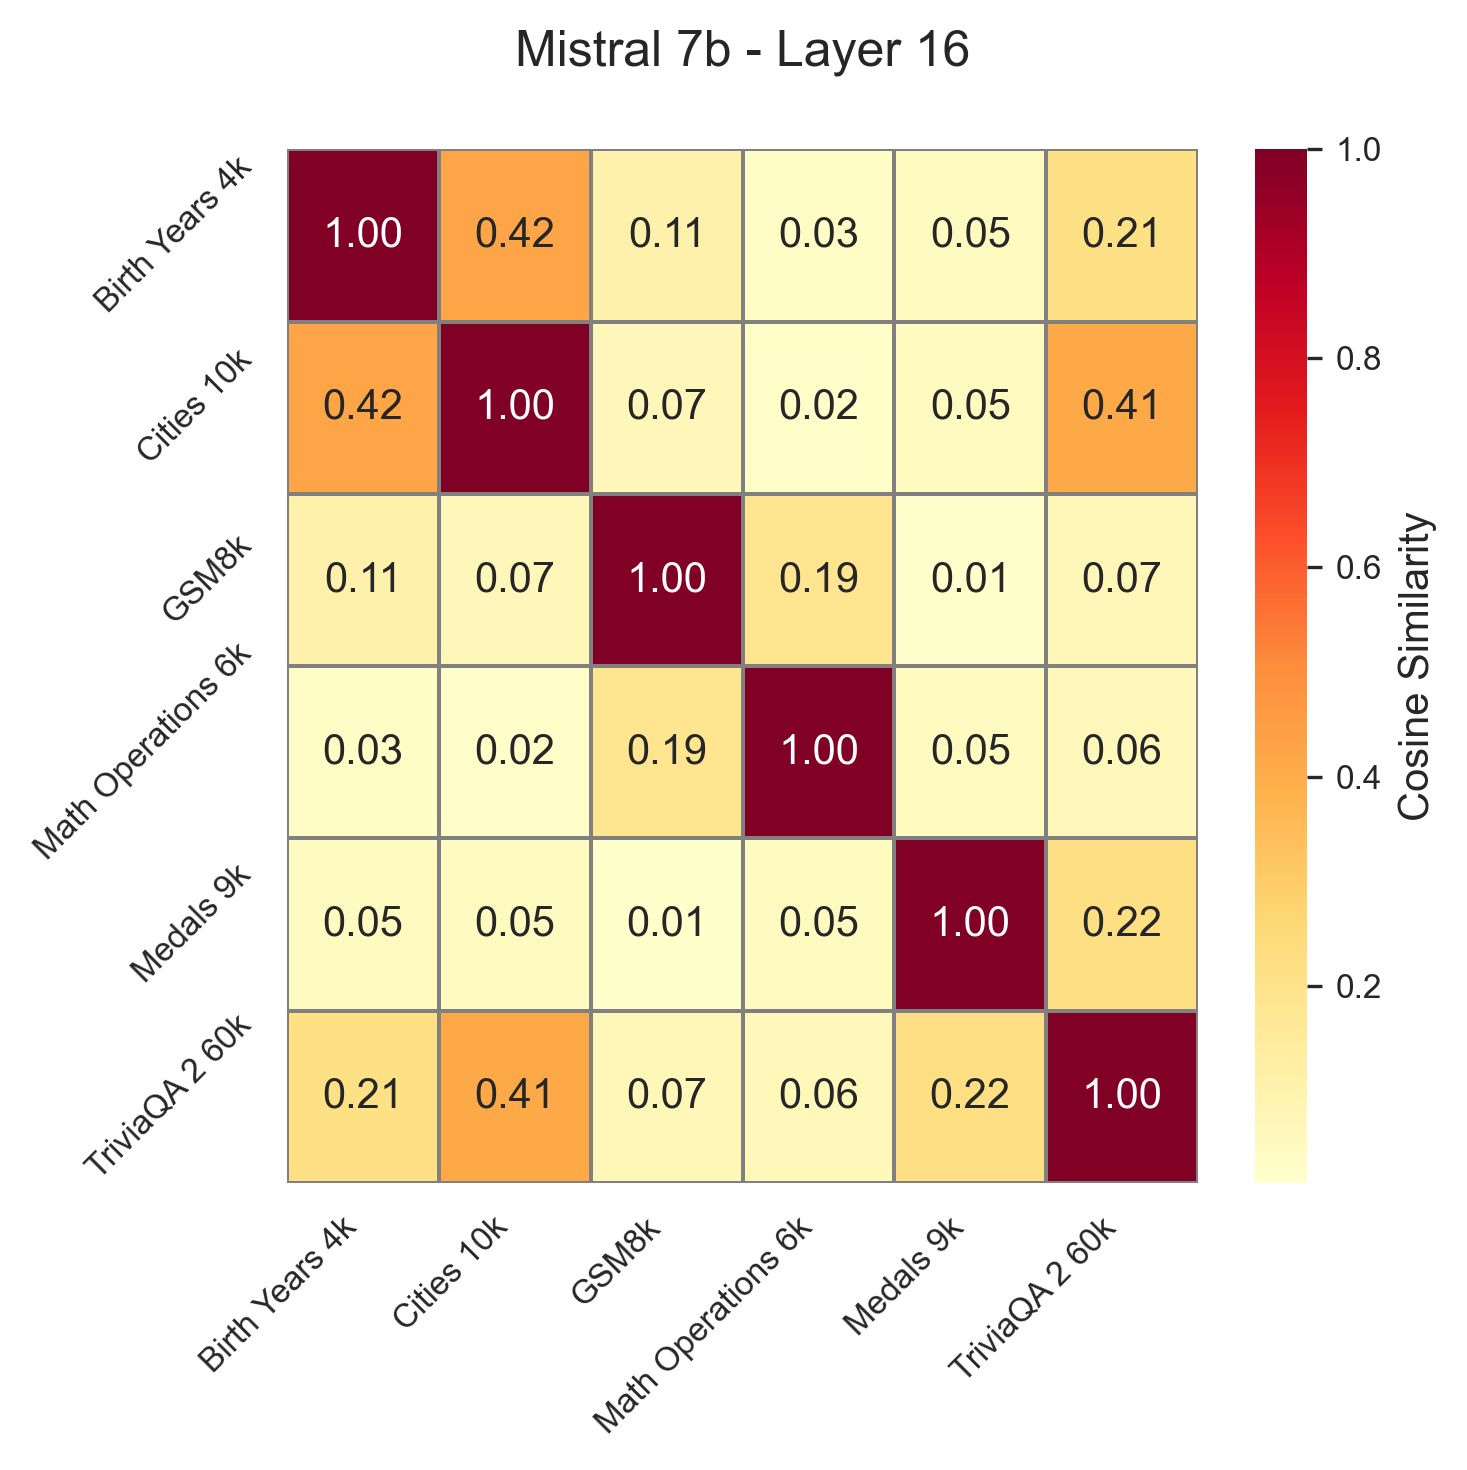

In [32]:
def heatmap_cosine_similarities_across_train_test_and_dataset_combinations(model_stats_dict, figsize=(6, 4), save_path=None):
    assert len(model_stats_dict) == 1, "Only one model is supported"
    model_name, model_dict = list(model_stats_dict.items())[0]
    dir_df = model_dict["dir_df"].copy()

    layer = model_dict["layer"]
    dir_df = dir_df[dir_df['layer'] == layer]

    heatmap_df = pd.DataFrame()
    for i, row_i in dir_df.iterrows():
        for j, row_j in dir_df.iterrows():
            heatmap_df.loc[
                DATASET_NAME_MAP[row_i["dataset_id_train"]],
                DATASET_NAME_MAP[row_j["dataset_id_train"]]
            ] = cosine_similarity_distribution(row_i["direction"], row_j["direction"])

    # heatmap_df = averaged.pivot(
    #     index="dataset_id_train",
    #     columns="dataset_id_test",
    #     values="cosine_similarities",
    # )
    # ax = sns.heatmap(data=heatmap_df, annot=True)
    # ax.set_xlabel("Test Dataset")
    # ax.set_ylabel("Train Dataset")
    # ax.set_title(f"{model_name} - Layer {layer}\nTest ROC AUCs")
    # plt.tight_layout()
    # plt.show()

    plt.figure(figsize=figsize, dpi=300)
    sns.set_style("whitegrid")
    sns.heatmap(
        heatmap_df,
        annot=True,
        fmt='.2f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Cosine Similarity'},
        linewidths=0.5,
        linecolor='gray'
    )
    # plt.gca().collections[0].set_clim(0.0, 1.0)  # Set colorbar range from 0.0 to 1.0
    plt.title(f'{model_name} - Layer {layer}', pad=20)
    # plt.xlabel('Test Dataset')
    # plt.ylabel('Train Dataset')
    plt.yticks(rotation=45, ha='right')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if save_path:
        plt.savefig(
            save_path, 
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=300
        )
    plt.show()
    

heatmap_cosine_similarities_across_train_test_and_dataset_combinations(
    {
            "Mistral 7b": {"dir_df": mistral_7b_directions_df, "layer": best_layer_mistral_7b},
    },
    figsize=(5, 5),
    save_path="mistral_7b_best_layer_cosine_similarities.pdf"
)